In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import random
import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/kaggle/input/bbdataplate/Dataset_Number/labels_my-project-name_2023-07-29-07-46-00.csv")
df.head()

,image_name,bbox_x,bbox_y,bbox_width,bbox_height
0,DSC_0968.JPG,378,459,144,85
1,DSC_0969.JPG,397,444,138,75
2,DSC_0970.JPG,499,554,164,98
3,DSC_0971.JPG,357,544,198,86
4,DSC_0971x.jpg,239,427,155,97


In [3]:
image_folder = "/kaggle/input/bbdataplate/Dataset_Number/Cars/"

# Read the image dimensions and normalize the bounding box values
for index, row in df.iterrows():
    image_path = os.path.join(image_folder, row["image_name"])
    image = cv2.imread(image_path)
    image_height, image_width, _ = image.shape

    df.at[index, "bbox_x"] = row["bbox_x"] / image_width
    df.at[index, "bbox_y"] = row["bbox_y"] / image_height
    df.at[index, "bbox_width"] = row["bbox_width"] / image_width
    df.at[index, "bbox_height"] = row["bbox_height"] / image_height


In [4]:
df.head()

,image_name,bbox_x,bbox_y,bbox_width,bbox_height
0,DSC_0968.JPG,0.425197,0.596879,0.161980,0.110533
1,DSC_0969.JPG,0.458960,0.622721,0.159538,0.105189
2,DSC_0970.JPG,0.494549,0.612155,0.162537,0.108287
3,DSC_0971.JPG,0.373041,0.628902,0.206897,0.099422
4,DSC_0971x.jpg,0.324288,0.616162,0.210312,0.139971


In [5]:
WIDTH = 299
HEIGHT = 299
CHANNEL = 3

def show_img(index):
    image = cv2.imread("/kaggle/input/bbdataplate/Dataset_Number/Cars/" + df["image_name"].iloc[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(WIDTH, HEIGHT))

    normalized_bbox_x = df["bbox_x"].iloc[index]
    normalized_bbox_y = df["bbox_y"].iloc[index]
    normalized_bbox_width = df["bbox_width"].iloc[index]
    normalized_bbox_height = df["bbox_height"].iloc[index]

    # Convert normalized bounding box values to pixel coordinates
    tx = int(normalized_bbox_x * WIDTH)
    ty = int(normalized_bbox_y * HEIGHT)
    bx = int((normalized_bbox_x + normalized_bbox_width) * WIDTH)
    by = int((normalized_bbox_y + normalized_bbox_height) * HEIGHT)

    # Draw the bounding box on the image
    image_with_bbox = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 2)

    plt.imshow(image_with_bbox)
    plt.show()


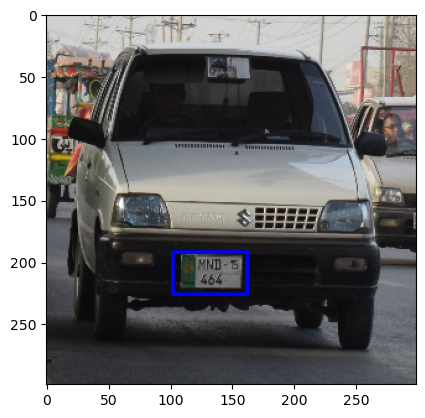

In [6]:
show_img(5)

In [7]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    df,
    directory="/kaggle/input/bbdataplate/Dataset_Number/Cars/",
    x_col="image_name",
    y_col=["bbox_x", "bbox_x", "bbox_width", "bbox_height"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    df,
    directory="/kaggle/input/bbdataplate/Dataset_Number/Cars/",
    x_col="image_name",
    y_col=["bbox_x", "bbox_x", "bbox_width", "bbox_height"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="validation")

Found 90 validated image filenames.
Found 10 validated image filenames.


In [8]:
from tensorflow.keras.applications import InceptionResNetV2
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(299,299,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dropout(0.25)(headmodel)
headmodel = Dense(125,activation="relu")(headmodel)
headmodel = Dropout(0.25)(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

219055592/219055592 [==============================] - 7s 0us/step


In [9]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
#model.summary()

In [10]:
tfb = TensorBoard('object_detection')
history = model.fit(train_generator,batch_size=32,epochs=150,
                    validation_data=validation_generator,callbacks=[tfb])

Epoch 1/150
3/3 [==============================] - 126s 5s/step - loss: 0.0877 - val_loss: 0.0482
Epoch 2/150
3/3 [==============================] - 3s 786ms/step - loss: 0.0862 - val_loss: 0.0299
Epoch 3/150
3/3 [==============================] - 3s 881ms/step - loss: 0.0852 - val_loss: 0.0297
Epoch 4/150
3/3 [==============================] - 3s 765ms/step - loss: 0.0875 - val_loss: 0.0284
Epoch 5/150
3/3 [==============================] - 3s 806ms/step - loss: 0.0794 - val_loss: 0.0501
Epoch 6/150
3/3 [==============================] - 3s 892ms/step - loss: 0.0789 - val_loss: 0.0566
Epoch 7/150
3/3 [==============================] - 3s 756ms/step - loss: 0.0681 - val_loss: 0.0314
Epoch 8/150
3/3 [==============================] - 3s 905ms/step - loss: 0.0505 - val_loss: 0.0369
Epoch 9/150
3/3 [==============================] - 3s 759ms/step - loss: 0.0372 - val_loss: 0.0293
Epoch 10/150
3/3 [==============================] - 3s 685ms/step - loss: 0.0286 - val_loss: 0.0264
Epoch 11/1

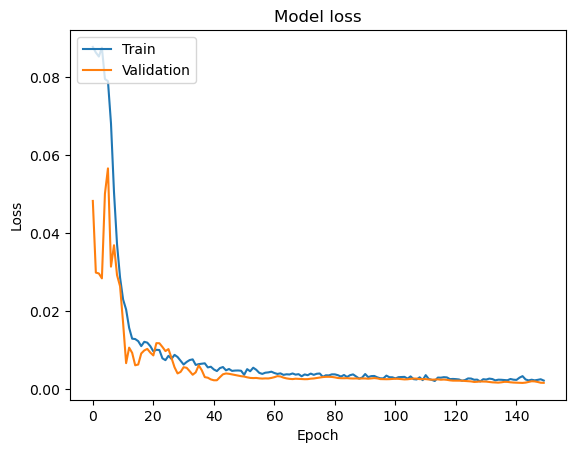

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
model.evaluate_generator(validation_generator)

0.0016804945189505816

1/1 [==============================] - 4s 4s/step


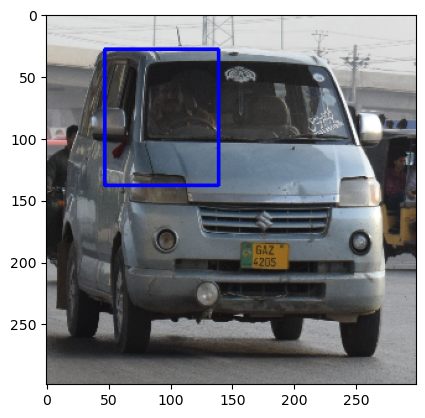

1/1 [==============================] - 0s 42ms/step


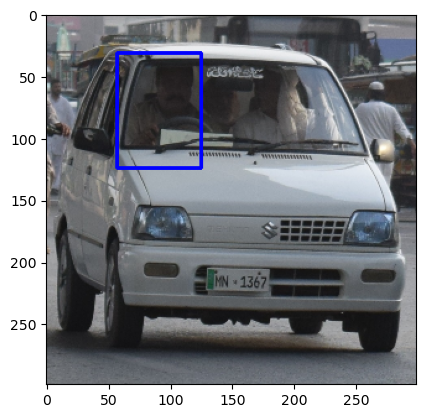

1/1 [==============================] - 0s 43ms/step


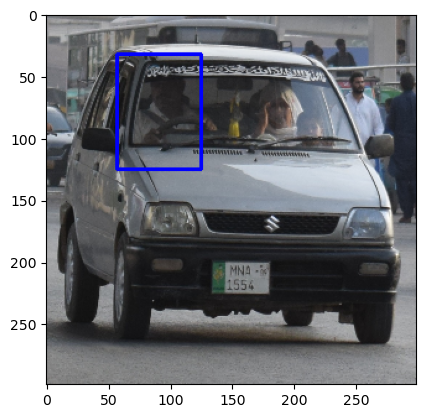

1/1 [==============================] - 0s 41ms/step


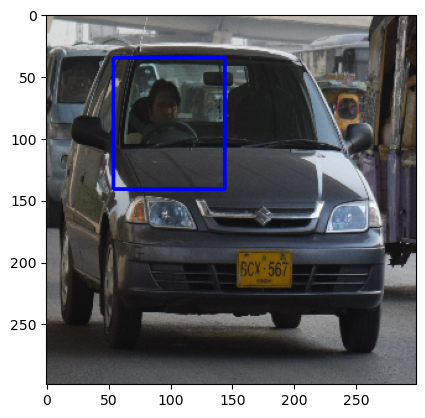

In [13]:
images_folder = "/kaggle/input/bbdataplate/Dataset_Number/Test/"
image_files = os.listdir(images_folder)

for image_file in image_files:
    img_path = os.path.join(images_folder, image_file)
    img = cv2.resize(cv2.imread(img_path) / 255.0, dsize=(WIDTH, HEIGHT))
    y_hat = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH

    xt, yt = int(y_hat[0]), int(y_hat[1])
    xb, yb = int(y_hat[2]), int(y_hat[3])

    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 0, 255), 2)
    plt.imshow(image)
    plt.show()
